In [99]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, isnan, when
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import time

spark_session = SparkSession.builder \
    .master("spark://192.168.2.156:7077") \
    .appName("DEI.G14.Project")\
    .config("spark.dynamicAllocation.enabled", True)\
    .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
    .config("spark.shuffle.service.enabled", False)\
    .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
    .config("spark.executor.cores",2)\
    .config("spark.driver.port",9999)\
    .config("spark.blockManager.port",10005)\
    .getOrCreate()

print("Spark session started successfully!")

Spark session started successfully!


In [100]:
# 定义文件路径和对应的数据集大小
file_paths = {
    "50k": "hdfs://192.168.2.156:9000/data/reddit/reddit_50k.json",
    "100k": "hdfs://192.168.2.156:9000/data/reddit/reddit_100k.json",
    "200k": "hdfs://192.168.2.156:9000/data/reddit/reddit_200k.json",
    "500k": "hdfs://192.168.2.156:9000/data/reddit/reddit_500k.json",
    # "1.5k": "hdfs://192.168.2.156:9000/data/G14data/redditdata_1.5k.json",
    # "15k": "hdfs://192.168.2.156:9000/data/G14data/redditdata_15k.json",
    # "150k": "hdfs://192.168.2.156:9000/data/G14data/redditdata_150k.json",
    "1500k": "hdfs://192.168.2.156:9000/data/G14data/redditdata_1500k.json"
}

# 选择要加载的数据集大小
dataset_size = "200k"  # 可以修改为 "50k", "100k", "200k", "500k", "1500k"
file_path = file_paths[dataset_size]

# 加载数据集
reddit_df = spark_session.read.json(file_path)

# 查看数据模式
reddit_df.printSchema()

# 查看前 5 行数据
reddit_df.show(5)

[Stage 57:=====================================================>  (21 + 1) / 22]

root
 |-- _corrupt_record: string (nullable = true)
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- content: string (nullable = true)
 |-- content_len: long (nullable = true)
 |-- id: string (nullable = true)
 |-- normalizedBody: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- summary_len: long (nullable = true)
 |-- title: string (nullable = true)

+---------------+----------------+--------------------+--------------------+-----------+-------+--------------------+-----------+------------+--------------------+-----------+-----+
|_corrupt_record|          author|                body|             content|content_len|     id|      normalizedBody|  subreddit|subreddit_id|             summary|summary_len|title|
+---------------+----------------+--------------------+--------------------+-----------+-------+--------------------+-----------+------------+-----

In [101]:
# 检查缺失值
reddit_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in reddit_df.columns]).show()

# 选择需要的列（author 和 body）
reddit_df = reddit_df.select("author", "body")

# 检查清洗后的数据
reddit_df.show(5)

[Stage 59:=====================================================>  (21 + 1) / 22]

+---------------+------+------+-------+-----------+------+--------------+---------+------------+-------+-----------+------+
|_corrupt_record|author|  body|content|content_len|    id|normalizedBody|subreddit|subreddit_id|summary|summary_len| title|
+---------------+------+------+-------+-----------+------+--------------+---------+------------+-------+-----------+------+
|         199278|200723|200723| 200723|     200723|200723|        200723|   200723|      200723| 200723|     200723|390187|
+---------------+------+------+-------+-----------+------+--------------+---------+------------+-------+-----------+------+

+----------------+--------------------+
|          author|                body|
+----------------+--------------------+
|raysofdarkmatter|I think it should...|
|            NULL|                NULL|
|         Stork13|Art is about the ...|
|            NULL|                NULL|
|   Cloud_dreamer|Ask me what I thi...|
+----------------+--------------------+
only showing top 5 

In [102]:
# 按用户分组并计算评论数量
start_time = time.time()
user_comment_count = reddit_df.groupBy("author").agg(count("body").alias("comment_count"))

# 将 comment_count 列转换为整数类型
user_comment_count = user_comment_count.withColumn("comment_count", col("comment_count").cast(IntegerType()))

end_time = time.time()

# 输出处理时间
processing_time = end_time - start_time
print(f"Time taken to process {dataset_size} dataset: {processing_time} seconds\n")

# 查看分组后的数据
user_comment_count.show(10)

Time taken to process 200k dataset: 0.025665283203125 seconds



[Stage 63:==================================================>     (20 + 2) / 22]

+------------------+-------------+
|            author|comment_count|
+------------------+-------------+
|    veni_vidi_vale|           21|
|   hoitytoityklutz|            1|
|            mjaybe|            4|
|             vulpa|            1|
|my_baby_ate_dingos|            3|
|         ZeusMcFly|            3|
|   WinSomeLoseNone|            1|
|     Echo_from_XBL|            1|
|       bfplayer123|            1|
|        maddog1095|            1|
+------------------+-------------+
only showing top 10 rows



In [103]:
# 将 Spark DataFrame 转换为 Pandas DataFrame
user_comment_count_pd = user_comment_count.toPandas()

# 统计所有不同次评论的数据
comment_counts = user_comment_count_pd['comment_count'].value_counts().sort_index()

# 输出结果到 txt 文件
output_file = f"result_{dataset_size}.txt"
with open(output_file, "w") as file:
    file.write(f"Results for {dataset_size} Dataset\n")
    file.write("=" * 30 + "\n")
    file.write("Comment Count\tNumber of Users\n")
    file.write("-" * 30 + "\n")
    for count, num_users in comment_counts.items():
        file.write(f"{count}\t\t{num_users}\n")
    file.write("=" * 30 + "\n")
    file.write(f"Total unique users: {len(comment_counts)}\n")
    file.write(f"Total comments: {comment_counts.sum()}\n")

print(f"Results saved to {output_file}")

Results saved to result_200k.txt


Histogram saved to picture_200k.png


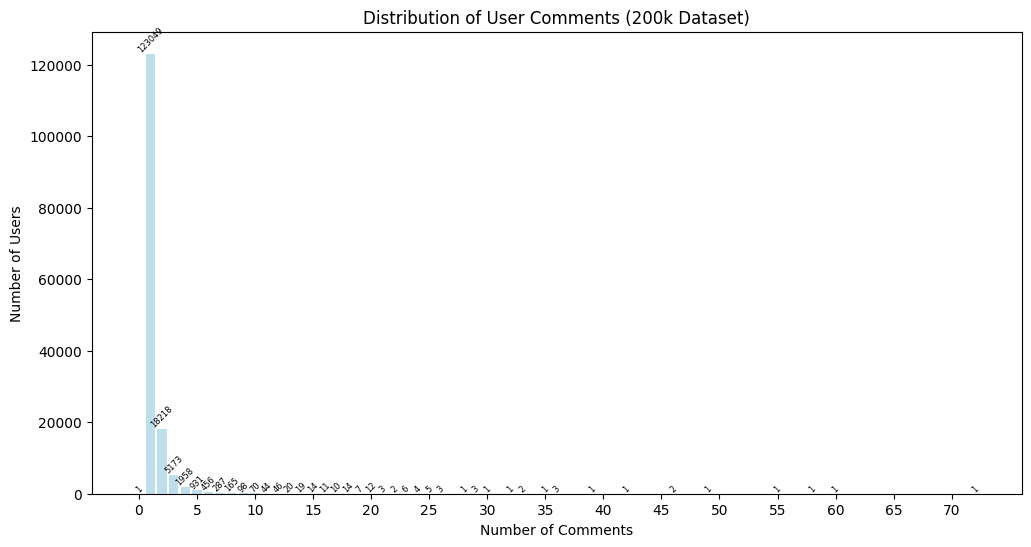

In [104]:
# 绘制直方图
plt.figure(figsize=(12, 6))
bars = plt.bar(comment_counts.index, comment_counts.values, color='lightblue', edgecolor='none', width=0.8, alpha=0.8)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, int(height), 
             ha='center', va='bottom', fontsize=6, rotation=45)  # 字体大小改为6

# 设置标题和坐标轴标签
plt.title(f'Distribution of User Comments ({dataset_size} Dataset)')
plt.xlabel('Number of Comments')
plt.ylabel('Number of Users')

# 如果 dataset_size 不是 500k 或 1500k，设置横坐标步长为5
if dataset_size not in ["500k", "1500k"]:
    plt.xticks(range(0, max(comment_counts.index) + 1, 5))

# 去掉网格线
plt.grid(False)

# 保存直方图为图片文件
histogram_file = f"picture_{dataset_size}.png"
plt.savefig(histogram_file, bbox_inches='tight', dpi=300)
print(f"Histogram saved to {histogram_file}")

# 显示图形
plt.show()

In [105]:
spark_session.stop()
print(f"Spark session finished!")

Spark session finished!
